# Train i-ResNet to solve inverse scattering problem

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from utils import ScatteringProblemIResNet
from visualizations import *


In [48]:
# this parameters work when I/100
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 100

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x     = 10
ndim_pad_x = 514

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 10


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert ( ndim_x + ndim_pad_x
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False

lambda_fit_forw         = 0.01
lambda_mmd_forw         = 100.
lambda_reconstruct      = 1.
lambda_mmd_back   = 500.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 7
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

In [3]:
learning_problem = ScatteringProblemIResNet(device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambda_fit_forw, lambda_mmd_forw, lambda_mmd_back, lambda_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
learning_problem.read_data('/home/slaskina/simulations')
learning_problem.normalize_inputs()

In [49]:
learning_problem.update_hyperparameters(device, batch_size, ndim_x, ndim_y, ndim_z, ndim_pad_x, ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambda_fit_forw, lambda_mmd_forw, lambda_mmd_back, lambda_reconstruct, mmd_back_weighted, y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [50]:
learning_problem.create_loaders()

In [51]:

input = Ff.InputNode(ndim_x+ndim_pad_x, name='input_class')

nodes = [input]
for i in range(N_blocks):
    nodes.append(Ff.Node([nodes[-1].out0],Fm.IResNetLayer, {'internal_size':hidden_layer_sizes, 
                                                'n_internal_layers':4, 
                                                'jacobian_iterations':12,
                                                'hutchinson_samples':1, 
                                                'fixed_point_iterations':20,
                                                'lipschitz_iterations':10,
                                                'lipschitz_batchsize':10,
                                                'spectral_norm_max':0.8,
                                                }, name='ires'+str(i)))
   
nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      

In [52]:
learning_problem.set_model(model)
learning_problem.set_optimizer()

In [53]:
learning_problem.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000          7.6933          2.1216          1.2237          7.7498          2.1073          1.2235
   001          7.6931          2.0033          1.2242          7.7507          1.7743          1.2224
   002          7.6907          1.4073          1.2262          7.7414          0.7581          1.2236
   003          7.6391          0.7863          1.2251          7.6565          0.9741          1.2251
   004          7.5408          1.0374          1.2255          7.5460          1.1060          1.2241
   005          7.4189          1.1166          1.2244          7.4211          1.1468          1.2226
   006          7.2926          1.1747          1.2246          7.3001          1.2308          1.2255
   007          7.1688          1.2475          1.2256          7.1988          1.2940          1.2236
   008          7.0154          1.3004  

In [54]:
df_train = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.train_indices), learning_problem.train_indices)
df_val = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.val_indices), learning_problem.val_indices) 
df_test = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.test_indices), learning_problem.test_indices)

Accuracy is 33.49%
[99.9145055571388, 0.1444669170759896, 0.141643059490085]
MSE for radius per shape for correctly identified instances as follows: sphere: 63809799019628199936.0000, hardsphere: 284.5298 and cylinder: 463.9882
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 137722122098088992.0000, hardsphere: 0.2349 and cylinder: 0.2465
MSE for cylinder length for correctly identified instances: 16977.4207
MSE for cylinder length polydispersity for correctly identified instances: 0.1674
MSE for cylinder length for correctly identified instances: 1.2739


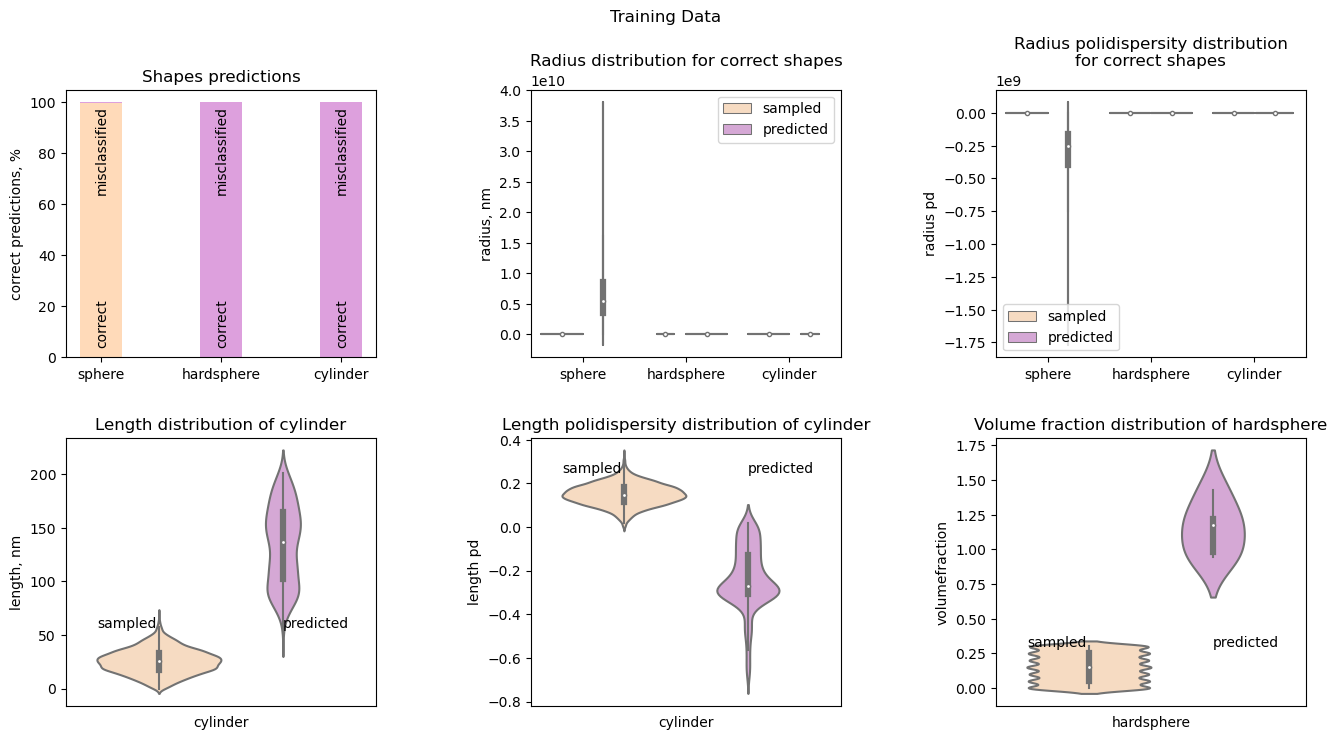

In [55]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 33.17%
[100.0, 0.09871668311944717, 0.30120481927710846]
MSE for radius per shape for correctly identified instances as follows: sphere: 63112763381328297984.0000, hardsphere: 135.8938 and cylinder: 478.9091
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 136217626614776528.0000, hardsphere: 0.3329 and cylinder: 0.2430
MSE for cylinder length for correctly identified instances: 16552.4211
MSE for cylinder length polydispersity for correctly identified instances: 0.1885
MSE for cylinder length for correctly identified instances: 0.9283


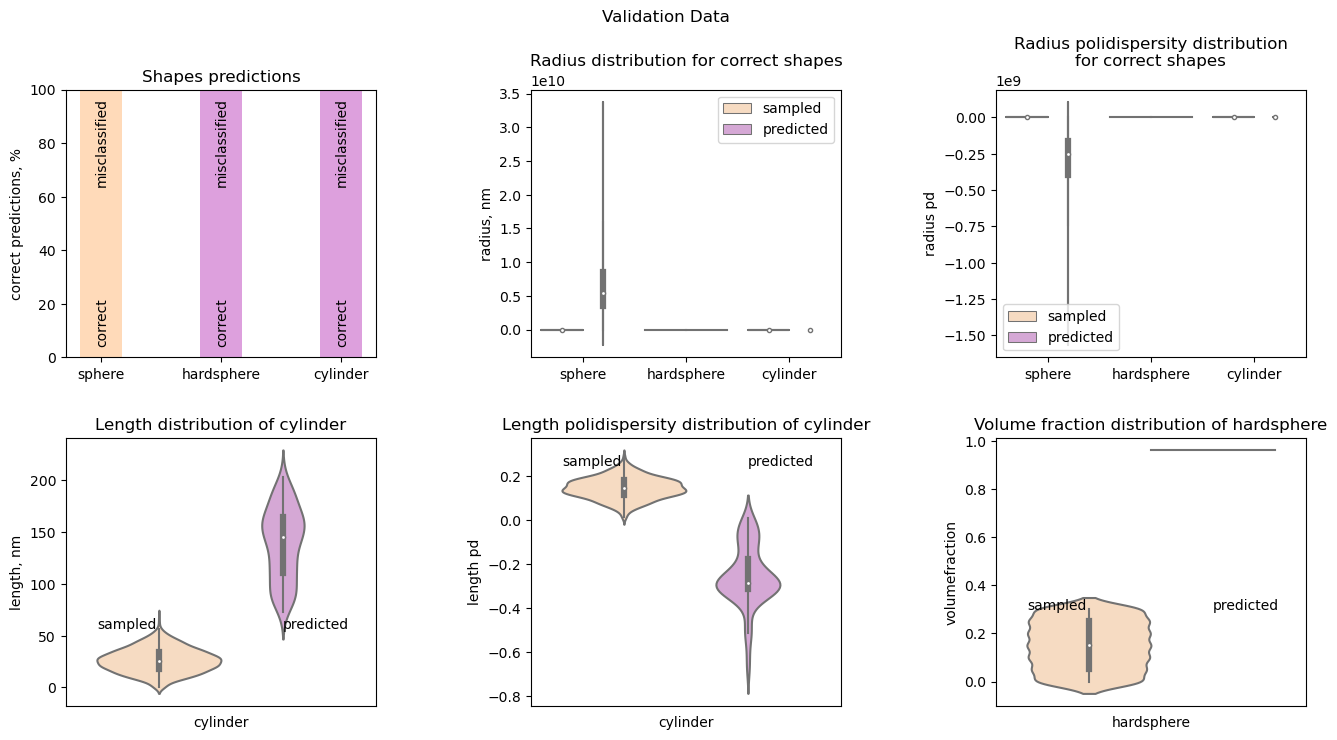

In [56]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 33.27%
[99.8, 0.0, 0.0]
MSE for radius per shape for correctly identified instances as follows: sphere: 58132021219795804160.0000, hardsphere: inf and cylinder: inf
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 125467579715379600.0000, hardsphere: inf and cylinder: inf
MSE for cylinder length for correctly identified instances: inf
MSE for cylinder length polydispersity for correctly identified instances: inf
MSE for cylinder length for correctly identified instances: inf


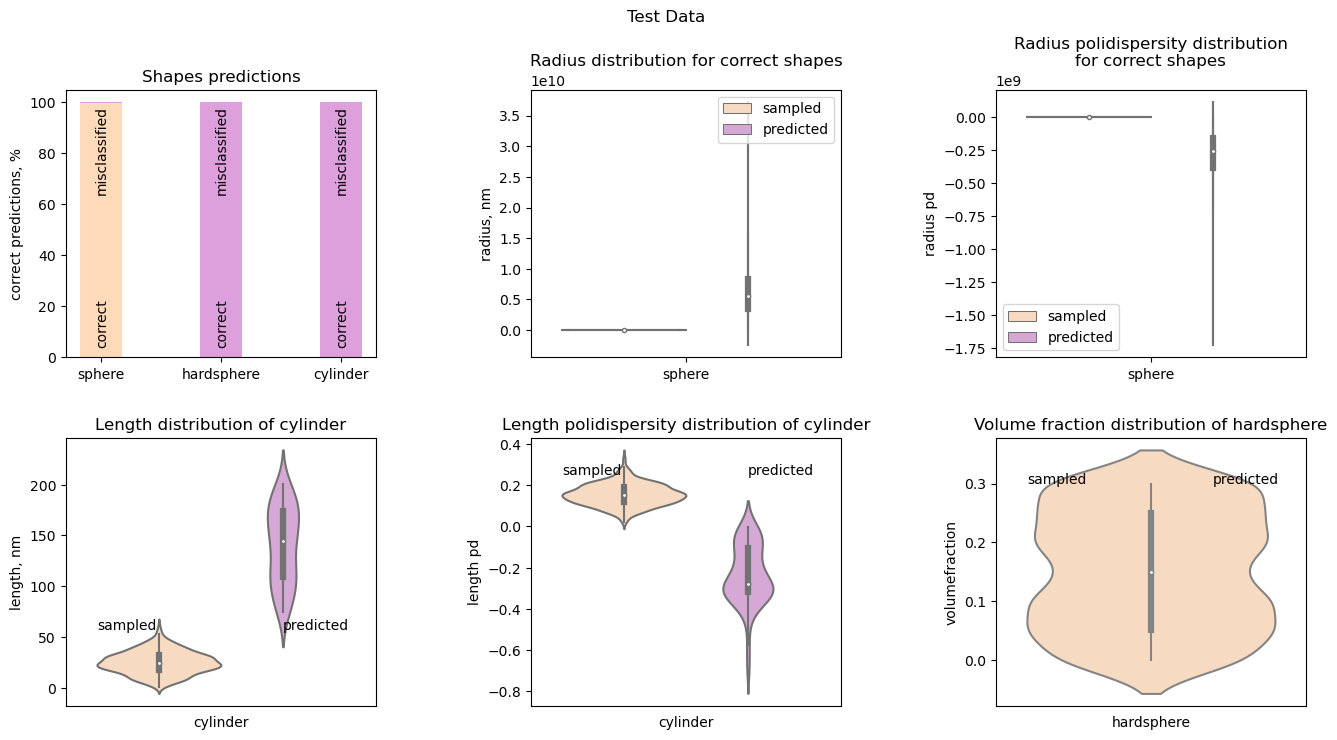

In [57]:
plot_outcomes_identified(df_test, 'Test')

### Does not really makes sense to look at the rest
it is fore more detailed results analysis



In [59]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

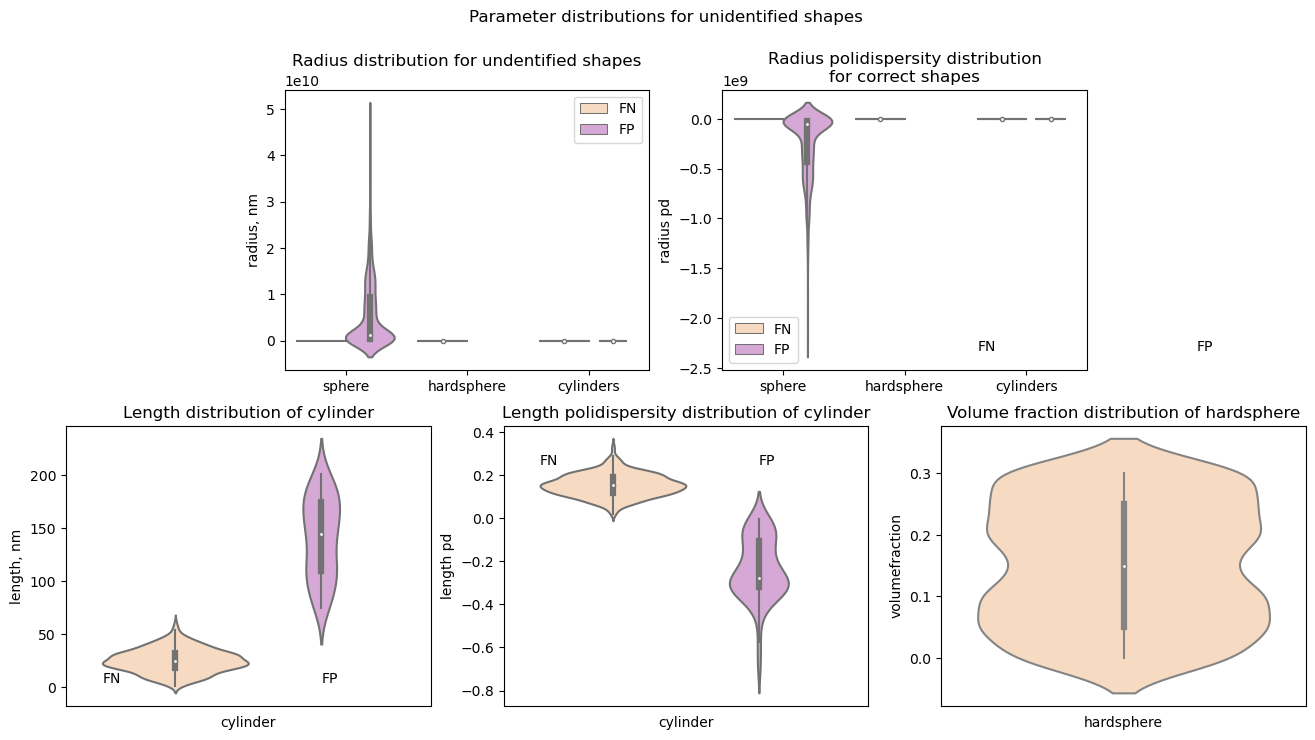

In [60]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

In [15]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,0,0,3.413588,799.919067,0.054327,4.398999,0.000000,-5314.001556,0.000000,24.653599,0.0,24.130784
1,1,0,2.980262,30.968000,0.061726,0.222779,0.000000,-192.989894,0.000000,1.197340,0.2,0.720109
2,1,1,1.641276,1.585311,0.068505,0.148848,0.000000,-54.255325,0.000000,0.782186,0.2,0.225945
3,0,0,4.041434,1447.557412,0.104213,4.233239,0.000000,-7963.798083,0.000000,34.593037,0.0,43.658127
4,2,0,4.509943,996.375055,0.084244,-31.514773,19.734676,-31507.471041,0.198257,63.307106,0.0,222.556000
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,1,8.030582,14549.657218,0.119405,-67.919561,0.000000,-58645.443670,0.000000,88.544185,0.0,444.252137
1496,2,1,7.841962,26173.352660,0.106468,-134.198866,19.113913,-97922.265283,0.182074,90.000260,0.0,779.634910
1497,2,0,1.514334,276.851107,0.079719,-4.141129,27.173893,-5152.450026,0.169102,12.808216,0.0,32.817130
1498,0,0,3.129840,450.574003,0.084106,4.517087,0.000000,-4212.552425,0.000000,19.615869,0.0,16.237036


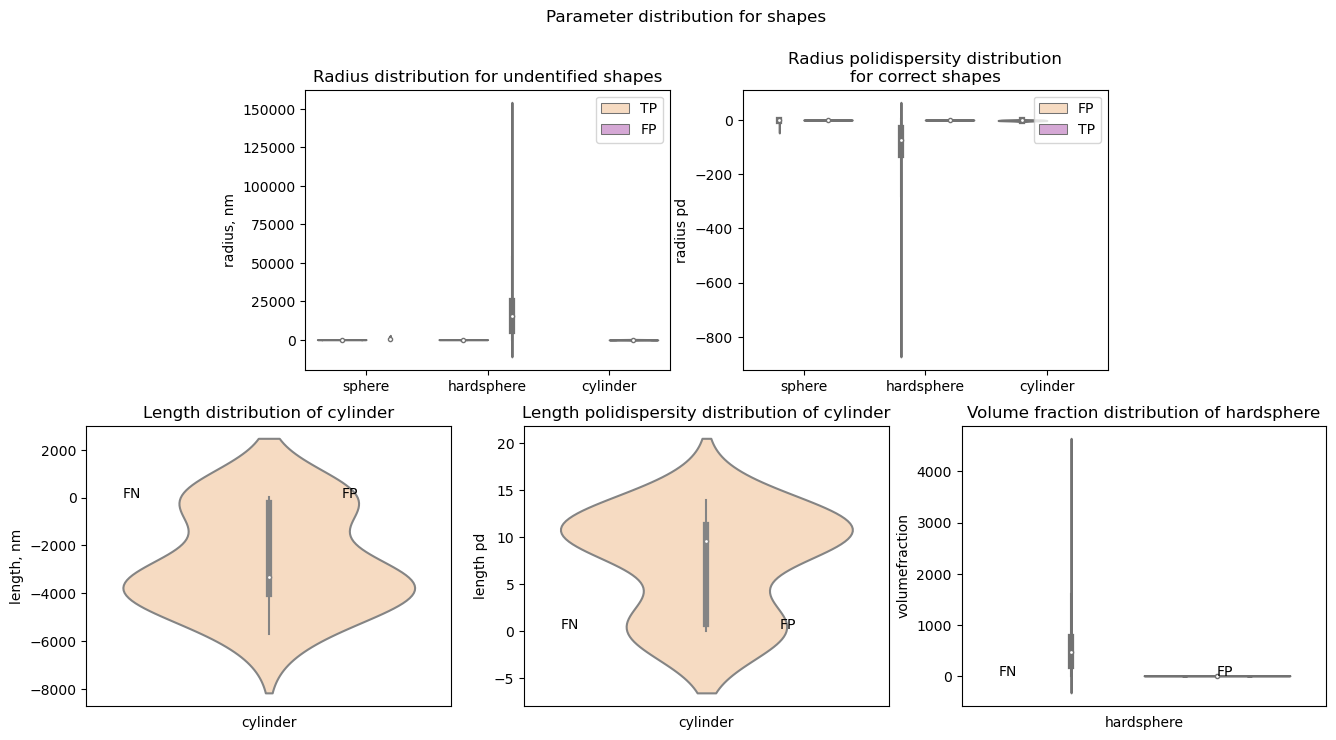

In [16]:
describe_positive_shapes(df_test)

## now look at the unidentified shapes more closely

In [17]:
def assign_class(row):
    if row[0]==1:
        return  'sphere'
    elif row[1] == 1:
        return 'hardsphere'
    elif row[2] == 1:
        return 'cylinder'
shapes_dict = {0:'sphere', 1:'hardsphere', 2:'cylinder'}

In [18]:
prediction_class = pd.DataFrame(make_prediction(labels[test_indices], model)[:,0:3])
prediction_class['true_class'] = pd.DataFrame(inputs[test_indices][:,0:3]).apply(assign_class, axis=1)
prediction_class['prediction'] = prediction_class[[0,1,2]].idxmax(axis=1)
prediction_class.replace({'prediction':shapes_dict}, inplace = True)

NameError: name 'make_prediction' is not defined

In [ ]:
unidentified_shapes = prediction_class[prediction_class.true_class != prediction_class.prediction]

In [ ]:
# shardpheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[2] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

            0         1         2  true_class prediction
109 -1.126322  5.907262  6.013777  hardsphere   cylinder


1

In [ ]:
# hardspheres id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[0] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')]) # unid hs

176

In [ ]:
# spheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=1) & (np.abs(unidentified_shapes[2] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
# spheres id as hs <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[1] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'sphere')])

496

In [ ]:
# cylinders id as hardspheres <=0.2
temp=unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[1] - unidentified_shapes[2])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
# cylinders id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=1) & (unidentified_shapes[0] - unidentified_shapes[2]<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')]

,0,1,2,true_class,prediction
20,-331.831696,1836.698853,1748.356689,cylinder,hardsphere
64,-0.058424,322.497375,300.776123,cylinder,hardsphere
94,-423.562592,2107.646240,2101.082764,cylinder,hardsphere
187,-462.227356,3359.415771,3233.230713,cylinder,hardsphere
188,-270.727966,1674.601685,1583.524414,cylinder,hardsphere
332,-518.434204,3983.504395,3849.356689,cylinder,hardsphere
335,0.755525,212.378647,206.649704,cylinder,hardsphere
341,-1760.075439,10274.632812,10136.971680,cylinder,hardsphere
363,2.442094,498.311676,459.822632,cylinder,hardsphere
384,-29.602364,19.670452,7.340857,cylinder,hardsphere


In [ ]:
#sphere_or_hardsphere
temp = prediction_class[(np.abs(prediction_class[0] - prediction_class[1])<0.4)& (prediction_class[[0,1,2]].idxmax(axis=1)!=2)]
temp.head()

,0,1,2,true_class,prediction


In [ ]:
len(temp[temp.true_class == temp.prediction])/len(temp)

ZeroDivisionError: division by zero

In [ ]:
import seaborn as sns

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


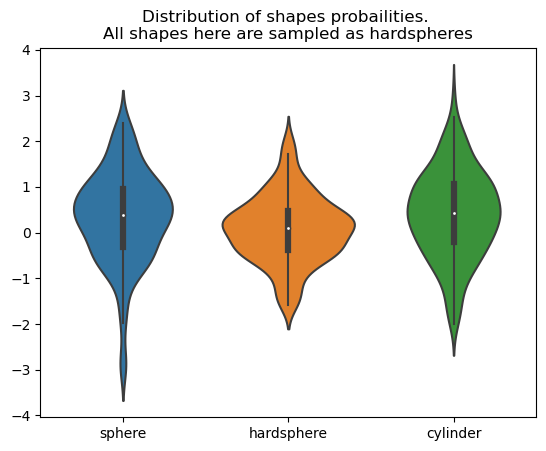

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'hardsphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as hardspheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


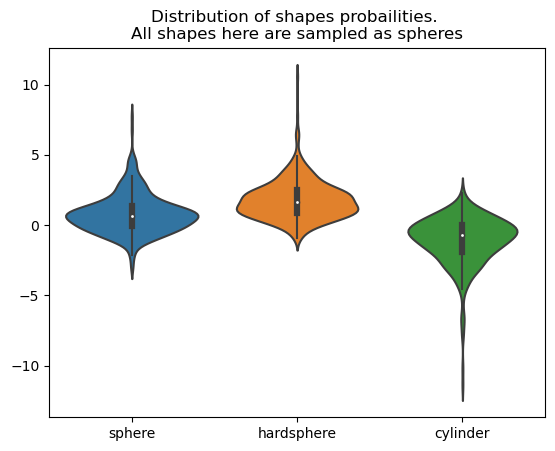

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'sphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


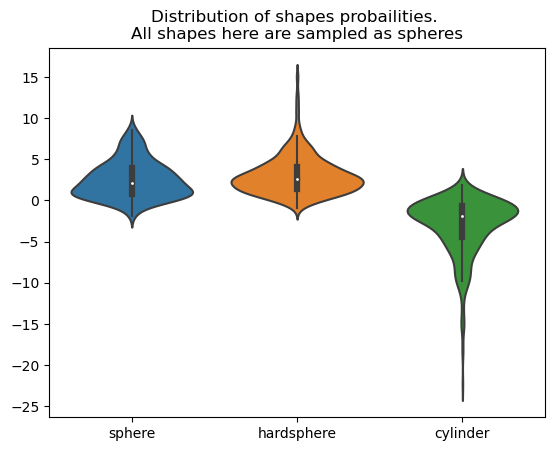

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'cylinder'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

In [ ]:
unidentified_shapes

,0,1,2,true_class,prediction
1,4.365447,4.547448,-4.620167,cylinder,hardsphere
2,-1.698165,0.074768,-0.324900,cylinder,hardsphere
3,1.752668,1.604691,0.917876,cylinder,sphere
4,0.594235,0.312561,1.078149,hardsphere,cylinder
5,0.802461,1.746982,-0.003059,sphere,hardsphere
...,...,...,...,...,...
1493,-1.067721,0.772532,-1.531655,cylinder,hardsphere
1494,0.477869,1.128571,-0.718903,sphere,hardsphere
1497,0.884562,1.792274,-1.255160,cylinder,hardsphere
1498,-0.039555,-0.236731,0.736277,sphere,cylinder


In [ ]:

scaler = torch.zeros(7,2)
learning_problem.inputs_norm = torch.clone(learning_problem.inputs)
for i in range(7):
    scaler[i,0] = learning_problem.inputs[:, 3+i].nanmean()
    nonzero_idx = torch.nonzero(learning_problem.inputs[:, 3+i]).reshape(1, -1)
    scaler[i,1] = learning_problem.inputs[:, 3+i][nonzero_idx].std()
    x = learning_problem.inputs_norm[:,3+i]
    learning_problem.inputs_norm[:,3+i] = torch.where( x!=0, (x -scaler[0,0]) / scaler[0,1],0)

In [ ]:
learning_problem.inputs_norm[:,4].max()

tensor(5.3957)

In [ ]:
torch.where(learning_problem.inputs_norm[:,4] !=0, (learning_problem.inputs_norm[:,4] -scaler[1,0]) / scaler[1,1],0)

tensor([0.0000, 0.0000, 0.0000,  ..., 1.8408, 5.8155, 4.5402])

In [ ]:
x = learning_problem.inputs_norm[:,3]

t = torch.where( x!=0, (x -scaler[0,0]) / scaler[0,1],0)

In [ ]:

x[5000:5010],t[5000:5010]

(tensor([ 7.1462,  4.7476,  6.1518,  5.2528,  6.8093,  5.2172,  3.0442, 10.1365,
          1.4171,  0.4824]),
 tensor([ 2.3392,  1.3083,  1.9118,  1.5254,  2.1944,  1.5101,  0.5761,  3.6246,
         -0.1232, -0.5250]))

In [ ]:
i = 0
b = t * scaler[i, 1] + scaler[i,0]

In [ ]:
b[5000:5010]

tensor([ 7.1462,  4.7476,  6.1518,  5.2528,  6.8093,  5.2172,  3.0442, 10.1365,
         1.4171,  0.4824])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fdfab1e7a90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fdf51b4b520>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fdfaad068b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fdf51b4e820>}

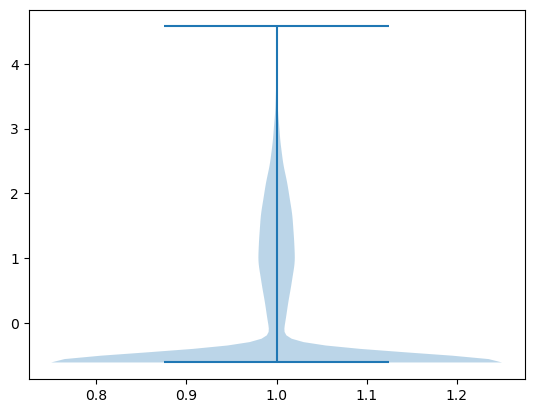

In [ ]:
plt.violinplot(learning_problem.inputs_norm[:, 4])